# 🌍 Global Ocean Satellite Analysis (2011-2015)
## Sea Surface Temperature (SST) & Height (SSH) Spatiotemporal Patterns

**Project Overview:**
This project utilizes Cloud Computing tools (Google Cloud Platform) to process and analyze massive satellite datasets. The objective is to study physical oceanographic variables (SST and SSH) over a 5-year period to identify global climate trends and anomalies.

**Tools used:** Python, Pandas, Matplotlib, Basemap, Scikit-learn, BigQuery.

**Contributors:** Paul Trassaert, Nathan Ygé, Aziz Jallouli, Mohammed Ali AL Marjani, Adam Denieul

In [1]:
%%capture
!pip install basemap

## Project Objective
Leveraging Cloud Computing (Google Cloud Platform) to process and analyze 5 years of real satellite ocean observations. The aim is to handle large datasets (~50GB) to extract meaningful patterns in Sea Surface Temperature (SST) and Height (SSH).

### Tech Stack & Libraries
* **Data Processing:** Pandas, Scikit-learn
* **Visualization:** Matplotlib, Pylab, Basemap (Geospatial projections)

In [2]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(20,20) # graph size

Populating the interactive namespace from numpy and matplotlib


### Utility Functions for Geospatial Plotting

In [3]:
# function to plot images
def plot_im(lon,lat,im,size_points,var_name):

    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)

    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='ortho',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)

    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)

# function to plot time series
def plot_ts(time,SST,line_type,var_name):

    # plot
    plot_date(time,SST,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

## Dataset Overview
We analyze a 5-year dataset (2011-2015) of daily global ocean observations with a 25km spatial resolution.
* Sea Surface Temperature (SST, °C) and Sea Surface Height (SSH, m).
* ~50GB of CSV files indexed by space (lon, lat) and time.

## 1. Exploratory Data Analysis (EDA) on Sample Data
Initial analysis performed on a subset (first 10 days of 2015, ~250MB) to establish baseline statistics and validate the visualization pipeline before scaling up to the full dataset.

In [ ]:
# sample of the dataset
data

lat      lon  sst      time     ssh
0       -77.625  322.625 -1.8  735600.0 -1.2535
1       -77.375  319.625 -1.8  735600.0 -1.2179
2       -77.375  319.875 -1.8  735600.0 -1.2214
3       -77.375  320.125 -1.8  735600.0 -1.2247
4       -77.375  320.375 -1.8  735600.0 -1.2285
...         ...      ...  ...       ...     ...
5338138  81.875   29.375 -1.8  735609.0 -0.3426
5338139  81.875   29.625 -1.8  735609.0 -0.3394
5338140  81.875   29.875 -1.8  735609.0 -0.3377
5338141  81.875   30.125 -1.8  735609.0 -0.3370
5338142  81.875   30.375 -1.8  735609.0     NaN

[5338143 rows x 5 columns]

In [ ]:
# statistics of the dataset
data.describe()

lat           lon           sst          time           ssh
count  5.338143e+06  5.338143e+06  5.338143e+06  5.338143e+06  5.338142e+06
mean  -1.140247e+01  1.932643e+02  1.646710e+01  7.356045e+05  3.436659e-01
std    3.845651e+01  1.003294e+02  1.041889e+01  2.871929e+00  7.254869e-01
min   -7.762500e+01  1.250000e-01 -1.800000e+00  7.356000e+05 -1.520300e+00
25%   -4.462500e+01  1.123750e+02  6.450000e+00  7.356020e+05 -3.170000e-02
50%   -1.587500e+01  1.971250e+02  1.950000e+01  7.356050e+05  5.697000e-01
75%    1.737500e+01  2.733750e+02  2.595000e+01  7.356070e+05  8.530000e-01
max    8.437500e+01  3.598750e+02  3.345000e+01  7.356090e+05  1.898000e+00

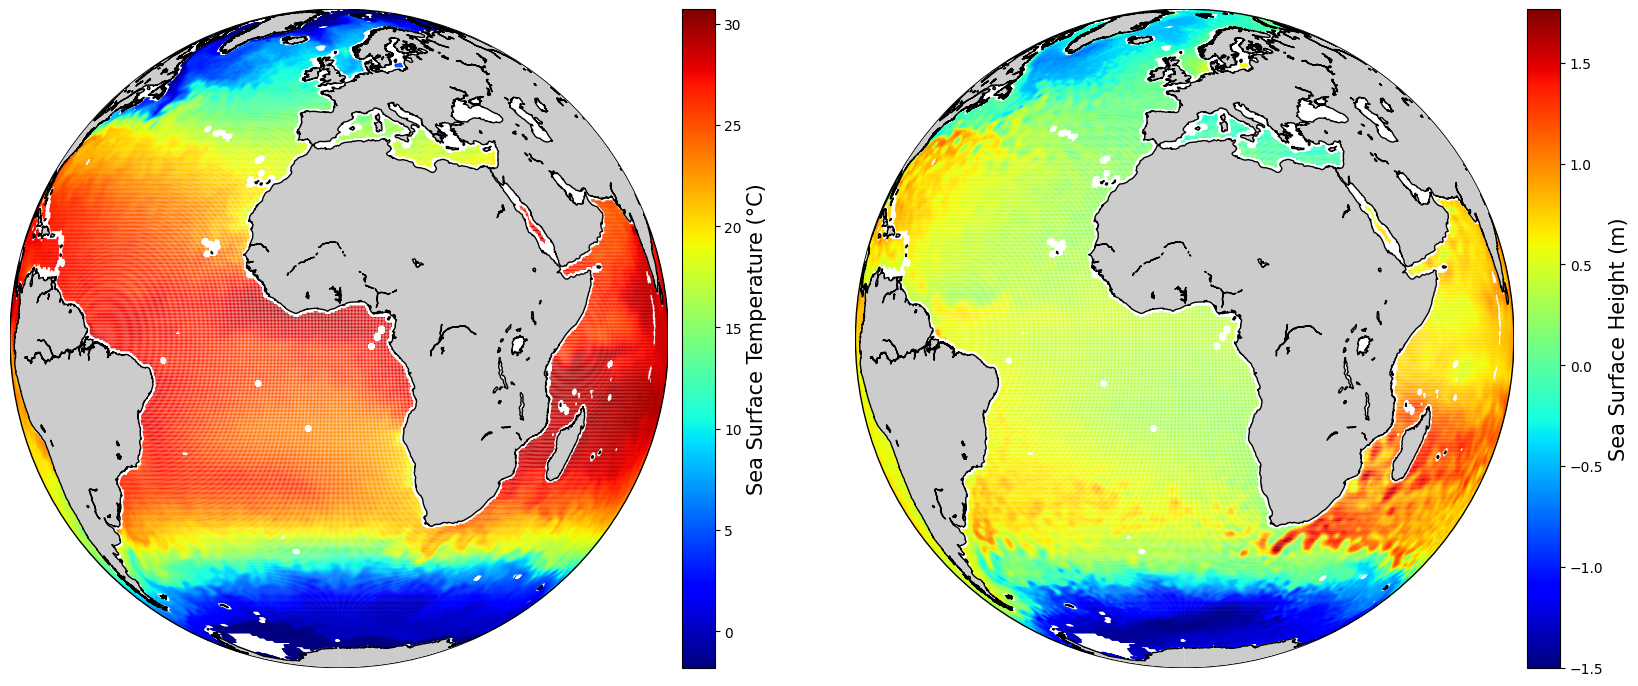

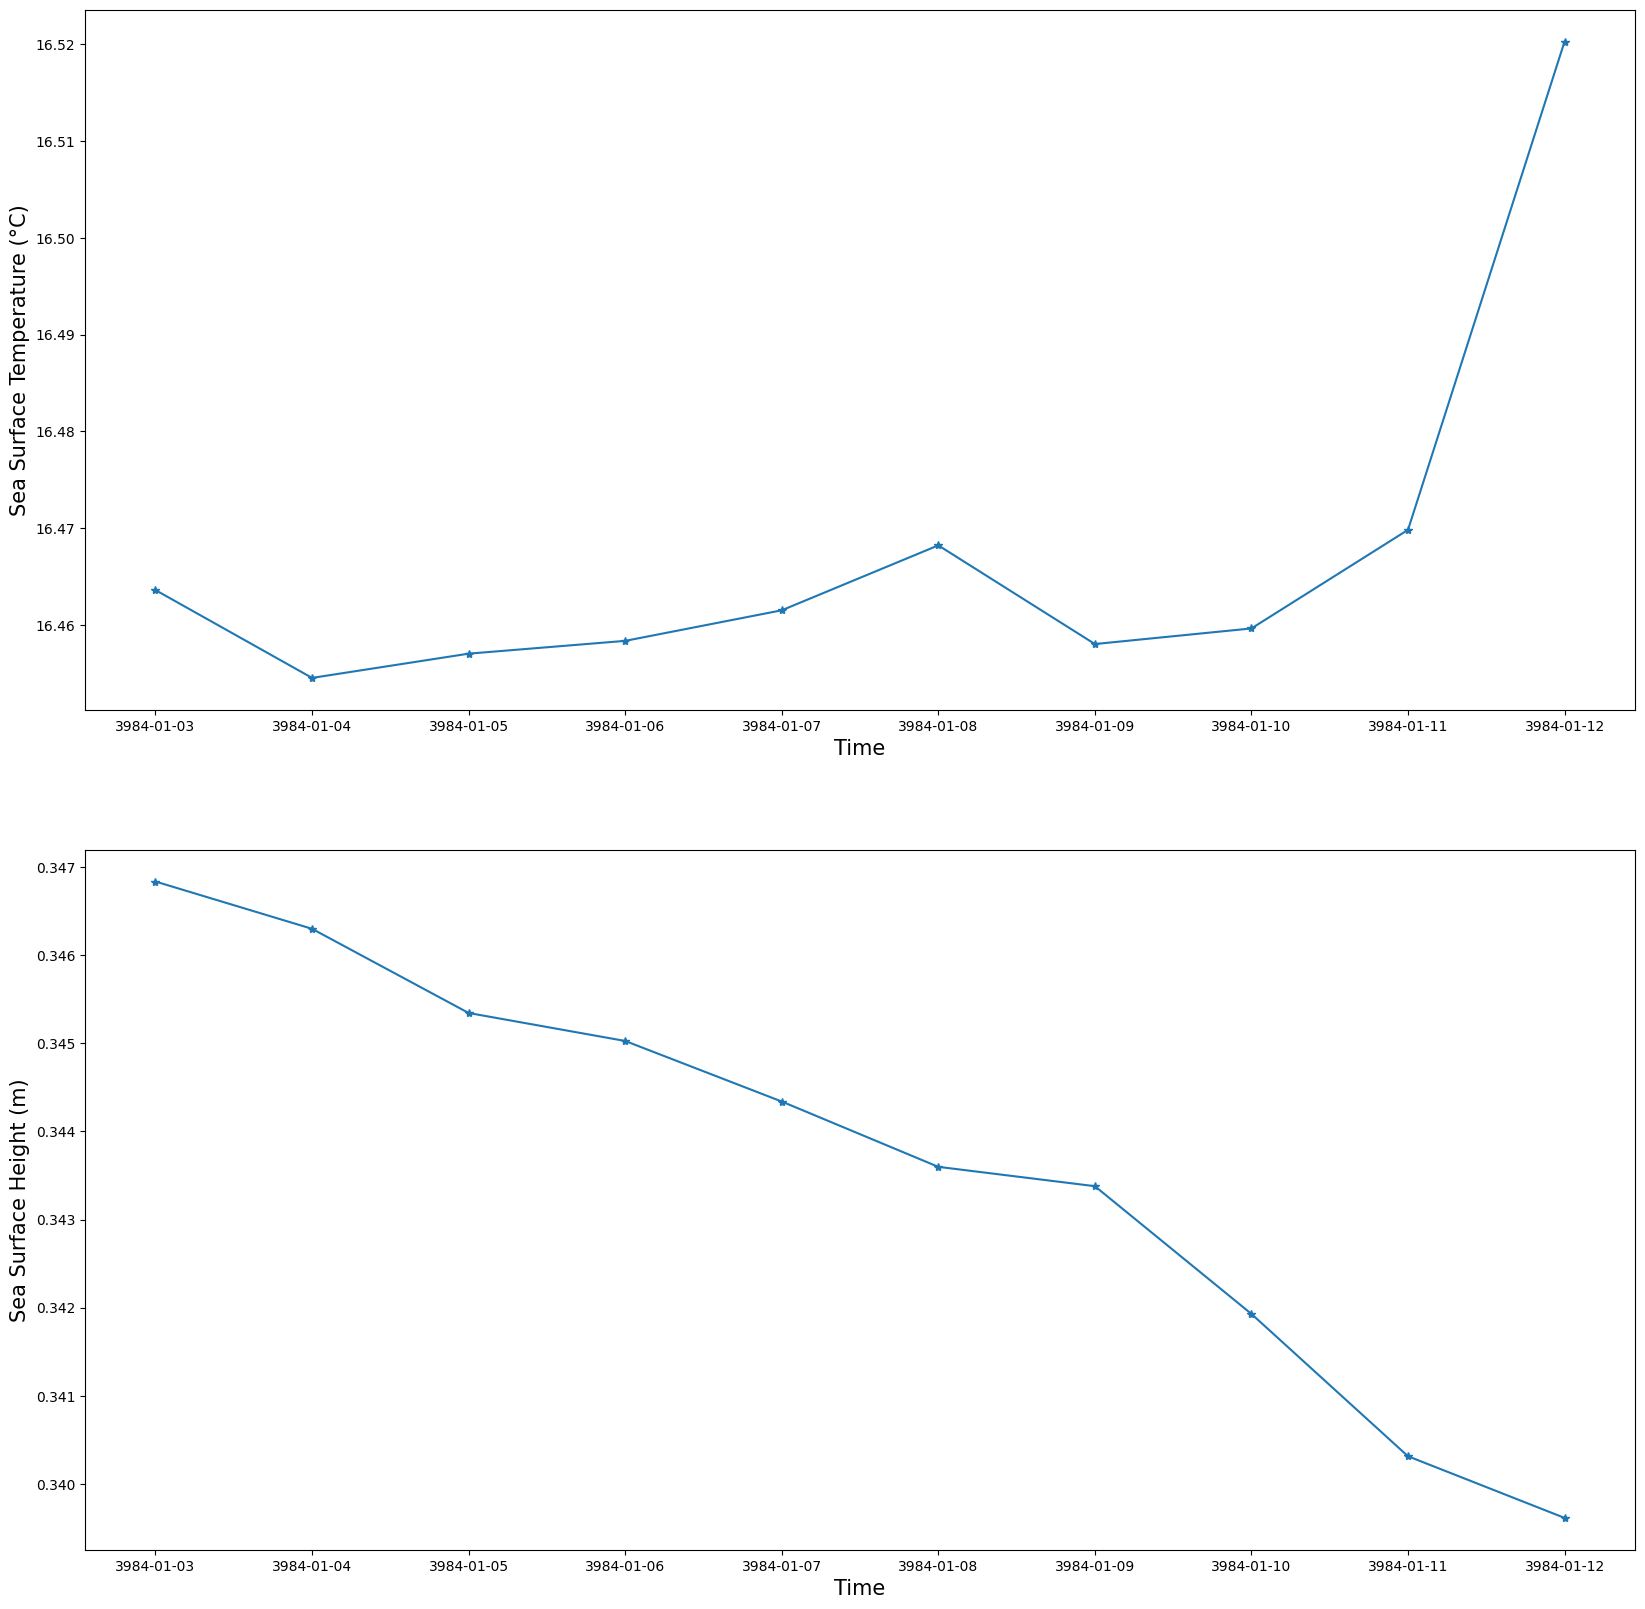

In [ ]:
# plot global SST and SSH maps
sst_im=data.groupby(['lon','lat'])['sst'].mean()
ssh_im=data.groupby(['lon','lat'])['ssh'].mean()
lon_im=data.groupby(['lon','lat'])['lon'].mean()
lat_im=data.groupby(['lon','lat'])['lat'].mean()
figure()
subplot(1,2,1)
plot_im(lon_im,lat_im,sst_im,1,'Sea Surface Temperature (°C)')
subplot(1,2,2)
plot_im(lon_im,lat_im,ssh_im,1,'Sea Surface Height (m)')

# plot global SST and SSH time series
sst_ts=data.groupby(['time'])['sst'].mean()
ssh_ts=data.groupby(['time'])['ssh'].mean()
time_ts=data.groupby(['time'])['time'].mean()
figure()
subplot(2,1,1)
plot_ts(time_ts,sst_ts,'-*','Sea Surface Temperature (°C)')
subplot(2,1,2)
plot_ts(time_ts,ssh_ts,'-*','Sea Surface Height (m)')

### Regional Focus: The Mediterranean Basin
In this section, we narrow the analysis to the Mediterranean Sea. This semi-enclosed basin offers specific thermodynamic characteristics suitable for studying the correlation between SST and SSH through histograms and scatter plots.

Text(0, 0.5, 'Sea Surface Height (m)')

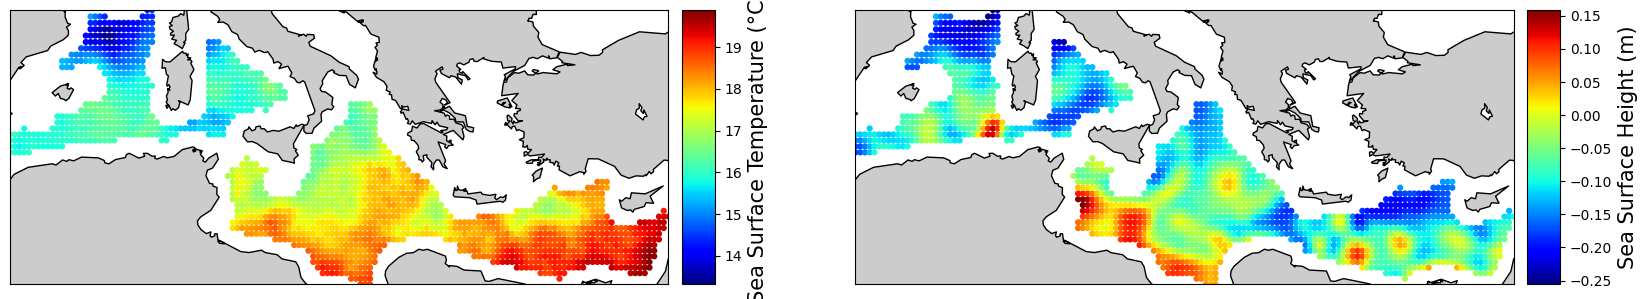

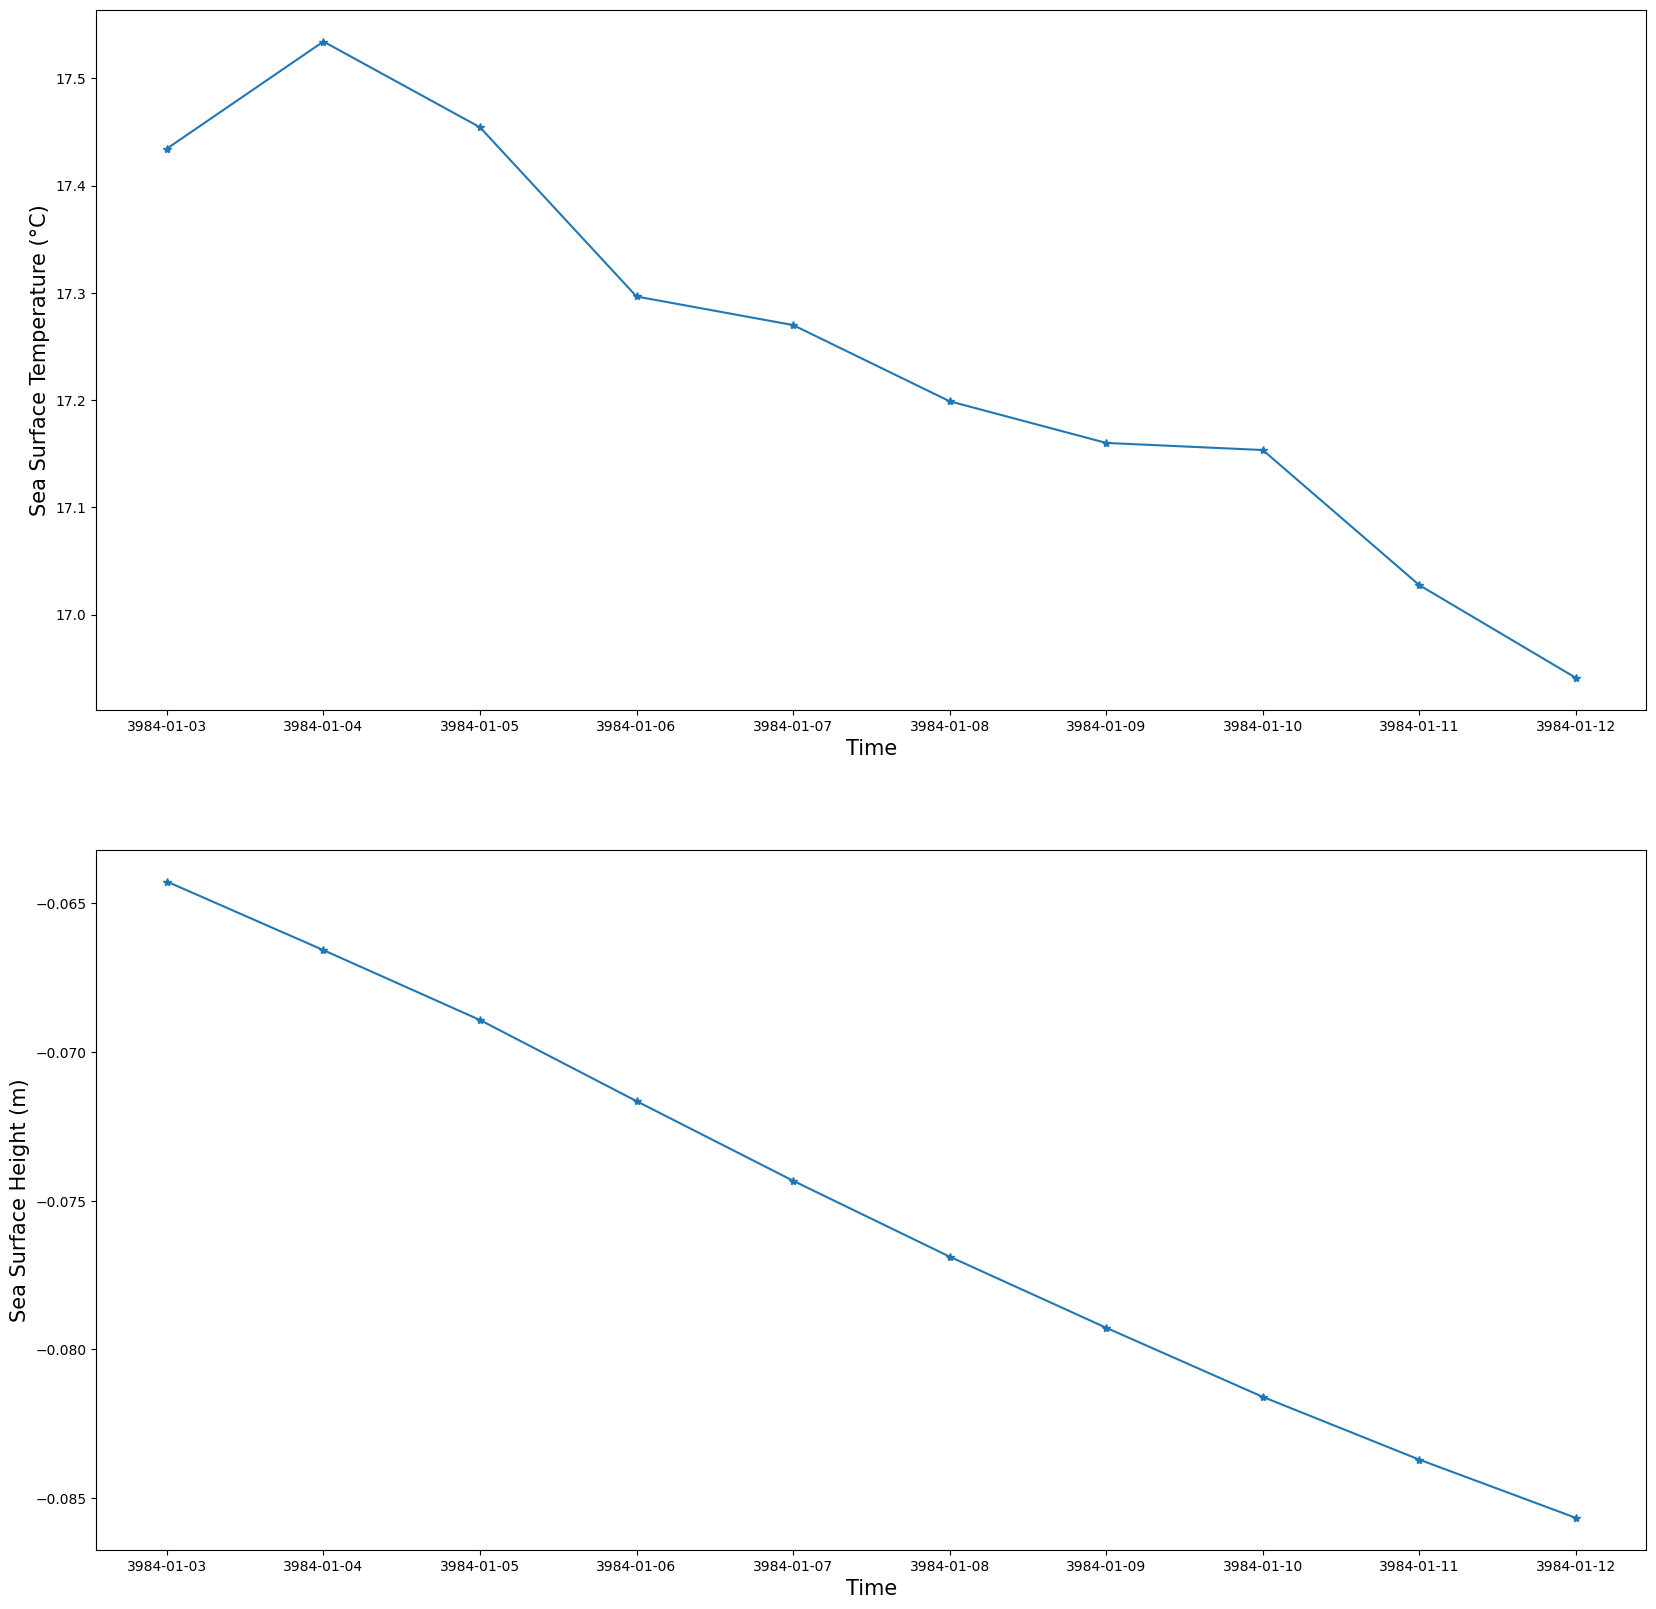

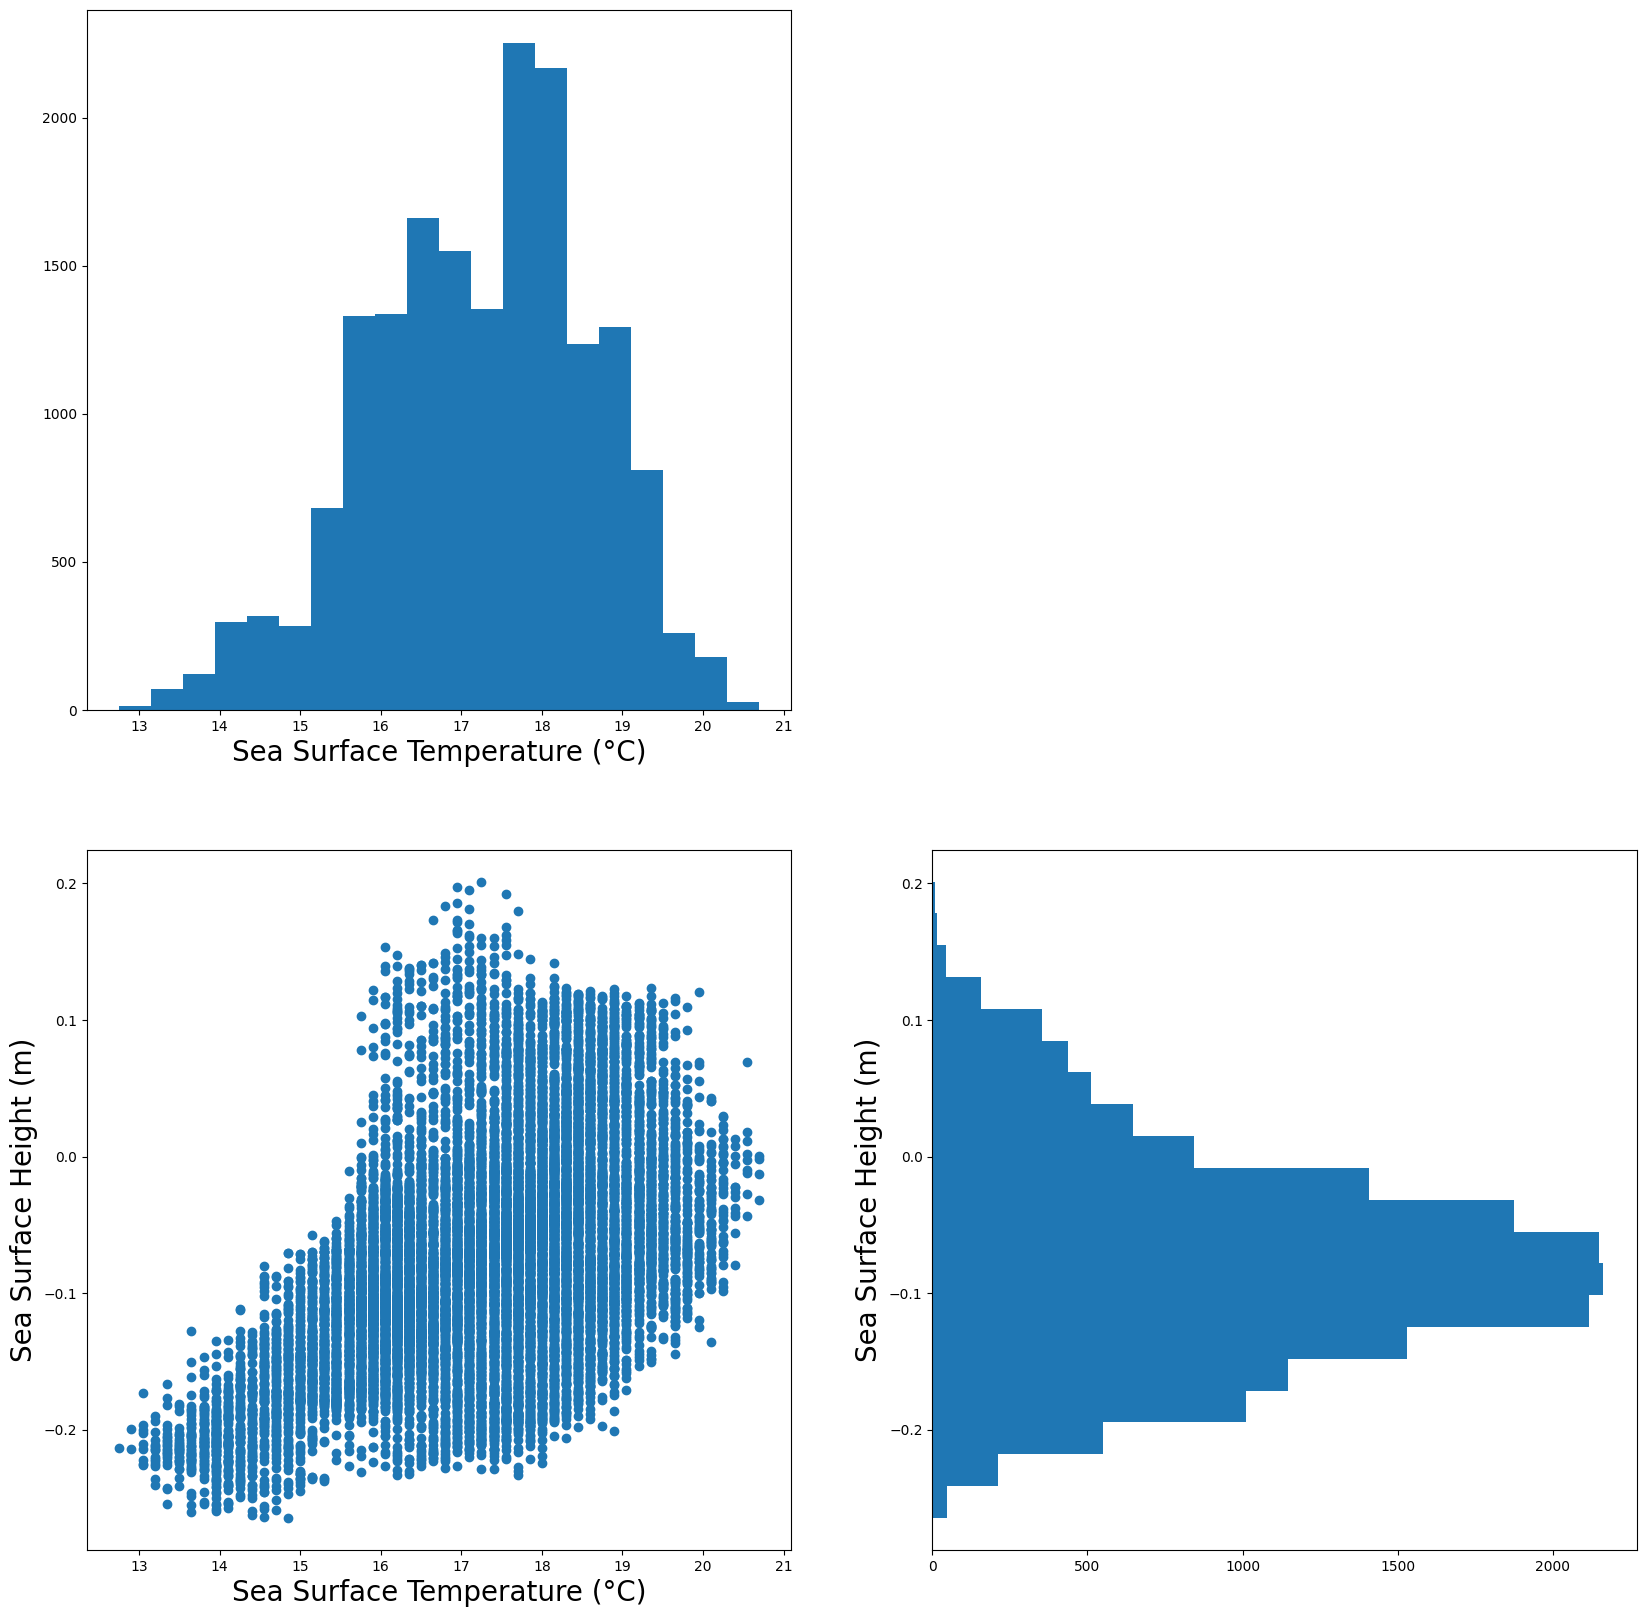

In [ ]:
# data selection
data_med=data[(data.lon>0) & (data.lon<35) & (data.lat>30) & (data.lat<45)]

# plot SST and SSH maps
sst_med_im=data_med.groupby(['lon','lat'])['sst'].mean()
ssh_med_im=data_med.groupby(['lon','lat'])['ssh'].mean()
lon_med_im=data_med.groupby(['lon','lat'])['lon'].mean()
lat_med_im=data_med.groupby(['lon','lat'])['lat'].mean()
figure()
subplot(1,2,1)
plot_im(lon_med_im,lat_med_im,sst_med_im,20,'Sea Surface Temperature (°C)')
subplot(1,2,2)
plot_im(lon_med_im,lat_med_im,ssh_med_im,20,'Sea Surface Height (m)')

# plot SST and SSH time series
sst_med_ts=data_med.groupby(['time'])['sst'].mean()
ssh_med_ts=data_med.groupby(['time'])['ssh'].mean()
time_med_ts=data_med.groupby(['time'])['time'].mean()
figure()
subplot(2,1,1)
plot_ts(time_med_ts,sst_med_ts,'-*','Sea Surface Temperature (°C)')
subplot(2,1,2)
plot_ts(time_med_ts,ssh_med_ts,'-*','Sea Surface Height (m)')

# plot hist(SST), hist(SSH), SSH~SST
figure()
subplot(2,2,1)
hist(data_med.sst, 20)
xlabel('Sea Surface Temperature (°C)', size=20)
subplot(2,2,4)
hist(data_med.ssh, 20, orientation=u'horizontal')
ylabel('Sea Surface Height (m)', size=20)
subplot(2,2,3)
scatter(data_med.sst, data_med.ssh)
xlabel('Sea Surface Temperature (°C)', size=20)
ylabel('Sea Surface Height (m)', size=20)

#### Scalability Challenge: From Local to Cloud
The previous analysis was limited to a local sample (250MB, 10 days). To process the full 5-year historical dataset (~50GB), local memory is insufficient. We therefore transition to a Cloud-Native approach using Google Cloud Platform.

## 2. Big Data Processing with Google BigQuery
We utilize BigQuery to perform SQL-like queries on the massive dataset directly within the cloud infrastructure, minimizing data transfer and optimizing computation time.

*Authentication requires valid GCP credentials with access to the `bigdataocean` project.*

In [4]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

from google.colab import auth
auth.authenticate_user()

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

### Cloud Data Architecture & Methodology
To handle the 5-year global dataset efficiently, we implement a hybrid pipeline:
1.  **Data Extraction (BigQuery):** We use SQL queries to perform heavy aggregations (mean, std, correlation) directly on the cloud server (`bdo2020` dataset).
2.  **Local Analysis (Python):** Aggregated results are fetched into Pandas DataFrames for advanced visualization and statistical modeling using Scikit-learn.

*Note: Time series extractions are explicitly ordered by timestamp to ensure temporal consistency.*

In [ ]:
%%bigquery output --project alert-ground-261008
SELECT lon, lat, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.2011_2015
WHERE lon>0 AND lon<35 AND lat>30 AND lat<45
GROUP BY lon, lat

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# sample of the dataframe
output

lon     lat   mean_sst
0     13.125  36.625  20.838582
1      0.125  37.375  20.465717
2      0.375  37.625  20.424644
3      3.875  37.625  20.414129
4      1.125  37.875  20.141402
...      ...     ...        ...
1718  17.875  36.625  21.092169
1719  20.125  36.875  21.137267
1720  34.125  33.125  23.342251
1721  22.125  34.625  20.982256
1722  18.375  38.375  20.576451

[1723 rows x 3 columns]

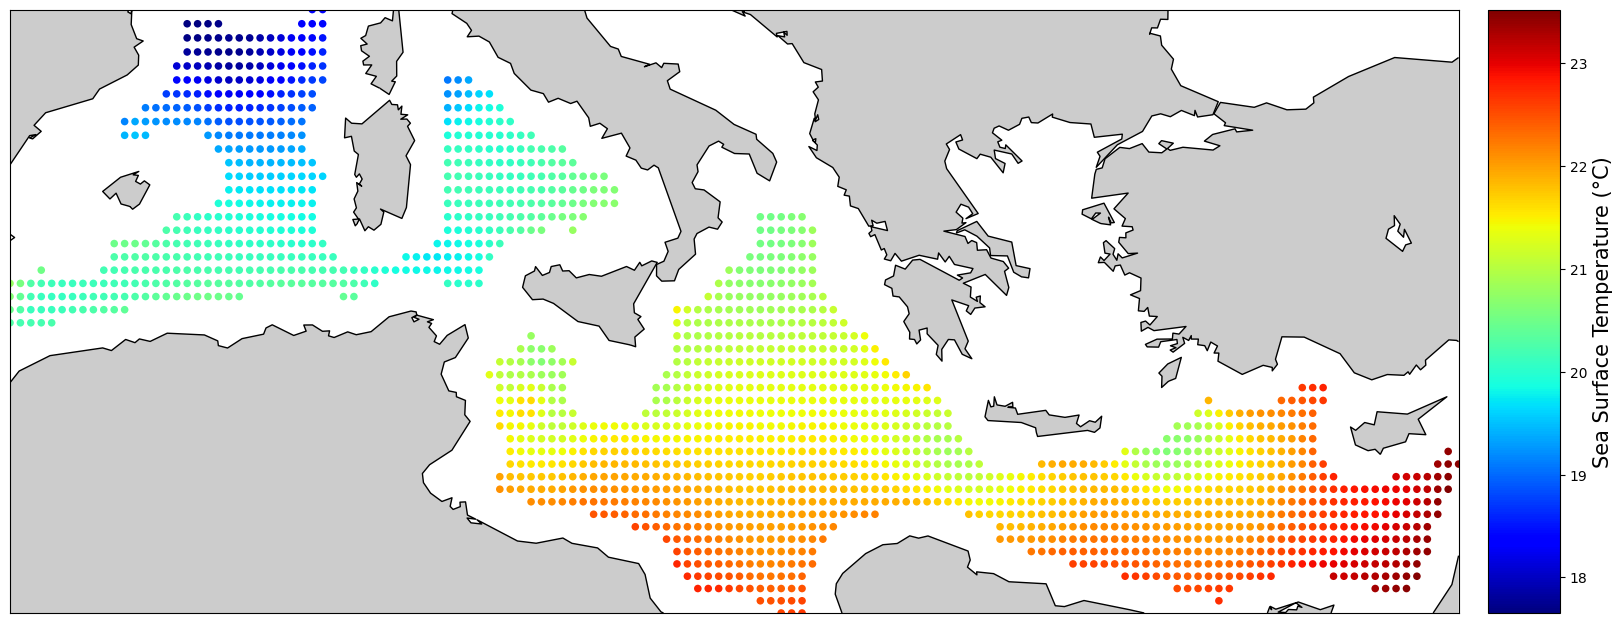

In [ ]:
plot_im(output.lon,output.lat,output.mean_sst,30,'Sea Surface Temperature (°C)')

SQL language is suitable to manipulate and compute basic statistics such as the mean, standard deviation, minimum, maximum, correlation, etc... Here you will find the list of basic functions: https://cloud.google.com/bigquery/docs/reference/legacy-sql?hl=fr.

The idea here is to extract the results of BigQuery and then use scikit-learn to perform some analysis: https://scikit-learn.org/stable/.

**Important note:** the tables stored in the Google Cloud Platform are not chronologically ordered. When dealing with time series, you will thus have to use *ORDER BY time* in your BigQuery requests.

### Case Study 1: The Agulhas Current Dynamics
**Region:** Longitudes (+15, +70), Latitudes (-50, -30).

**Objective:**
Investigate the correlation between Sea Surface Temperature (SST) and Sea Surface Height (SSH) in this highly energetic region. The Agulhas current is known for intense mesoscale variability, making it an ideal candidate to observe strong thermodynamic-dynamic coupling.

In [ ]:
# This query retrieves lon/lat and the averages (sst, ssh) and CORR(sst,ssh) per cell.

%%bigquery output_q1 --project alert-ground-261008
SELECT lon, lat, AVG(sst) AS mean_sst, AVG(ssh) AS mean_ssh ,  CORR(sst, ssh) AS corr_sst_ssh
FROM bdo2020.bdo2020.2011_2015
WHERE lon>15 AND lon<70 AND lat>-50 AND lat<-30
GROUP BY lon, lat
HAVING COUNTIF(sst IS NOT NULL AND ssh IS NOT NULL) >= 2

Query is running:   0%|          |

Downloading:   0%|          |

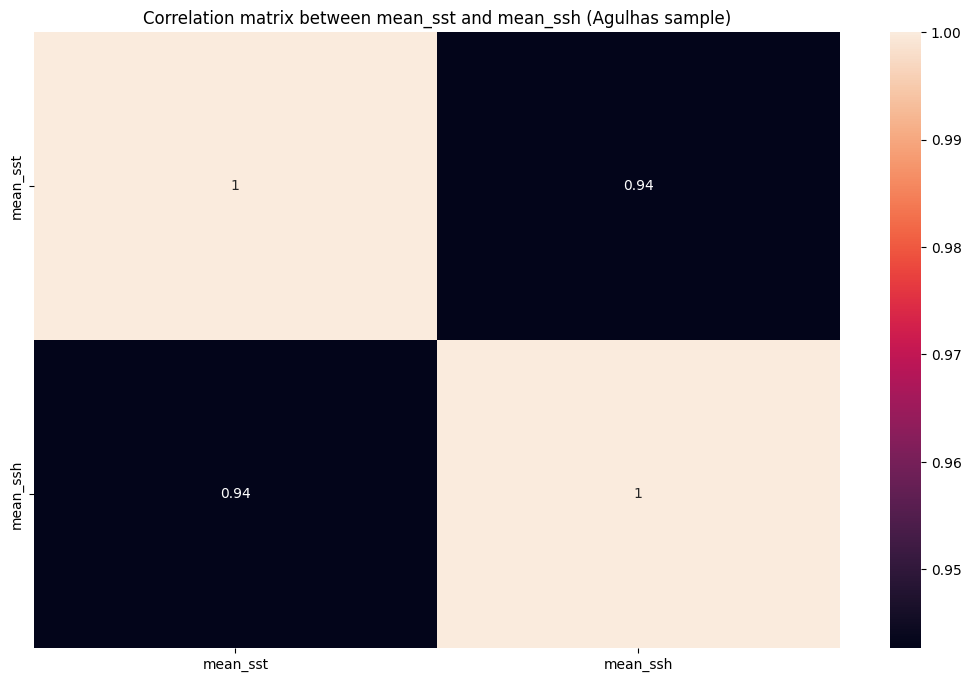

In [ ]:
## correlation matrix between mean_sst and mean_ssh (Agulhas sample)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


df = pd.DataFrame(output_q1[['mean_sst', 'mean_ssh']])

Cor_sst_ssh = df.corr(method='pearson')

plt.figure(figsize = (13,8))
plt.title("Correlation matrix between mean_sst and mean_ssh (Agulhas sample)")
sns.heatmap(Cor_sst_ssh, annot = True )
plt.show()

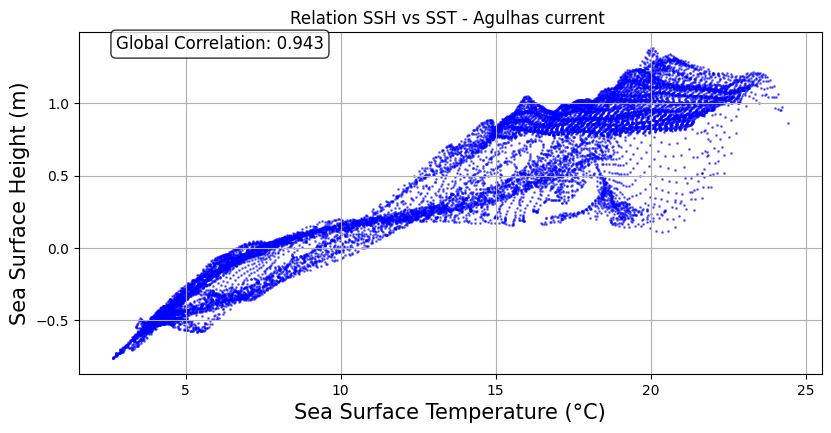

In [ ]:
# SSH vs SST scatter 

plt.figure(figsize=(16, 8))

plt.subplot(2,2,3)
plt.scatter(output_q1['mean_sst'], output_q1['mean_ssh'], alpha=0.5, s=1, color='blue')
plt.xlabel('Sea Surface Temperature (°C)', size=15)
plt.ylabel('Sea Surface Height (m)', size=15)
plt.title('Relation SSH vs SST - Agulhas current ')
plt.grid(True)


correlation_global = output_q1['mean_sst'].corr(output_q1['mean_ssh'])
plt.text(0.05, 0.95, f'Global Correlation: {correlation_global:.3f}',
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

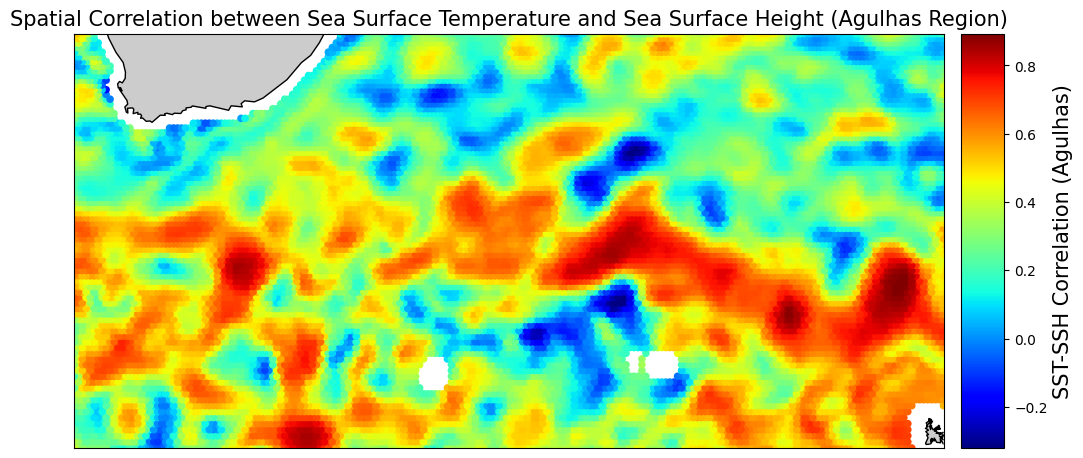

In [ ]:
# Correlation map SST vs SSH
df_corr = pd.DataFrame(output_q1[['lon', 'lat', 'corr_sst_ssh']])

plt.figure(figsize=(12, 10))
plot_im(df_corr['lon'], df_corr['lat'], df_corr['corr_sst_ssh'], 30, 'SST-SSH Correlation (Agulhas)')
plt.title('Spatial Correlation between Sea Surface Temperature and Sea Surface Height (Agulhas Region)', size=15)
plt.show()

The high covariance (≈ 0.94) between sea surface height (SSH) and sea surface temperature (SST) indicates a strong positive correlation between these two variables. This relationship suggests that increases in SST are generally associated with rises in SSH. Physically, this can be explained by the thermal expansion of seawater: as temperature increases, water density decreases, leading to an increase in sea level. In addition, this strong correlation may also reflect broader climate-related processes, such as ocean circulation variability or large-scale phenomena like ENSO, which simultaneously influence both SST and SSH.

### Case Study 2: ENSO Monitoring (El Niño / La Niña)
**Region:** Equatorial Pacific (Lon +180 to +300, Lat -20 to +20).

**Analysis:**
We compute the **ENSO Index** by plotting the daily mean and standard deviation of SST over the 5-year period.
* **Goal:** Identify warm phases (El Niño) and cold phases (La Niña) by analyzing thermal anomalies in the Pacific basin.

In [ ]:
# Request calculating mean and stddev of SST over a specified region and time period
%%bigquery output_q2 --project alert-ground-261008
SELECT time, AVG(sst) AS mean_sst, STDDEV(sst) AS std_sst
FROM bdo2020.bdo2020.2011_2015
WHERE lon>180 AND lon<300 AND lat>-20 AND lat<20
GROUP BY time
ORDER BY time

Query is running:   0%|          |

Downloading:   0%|          |

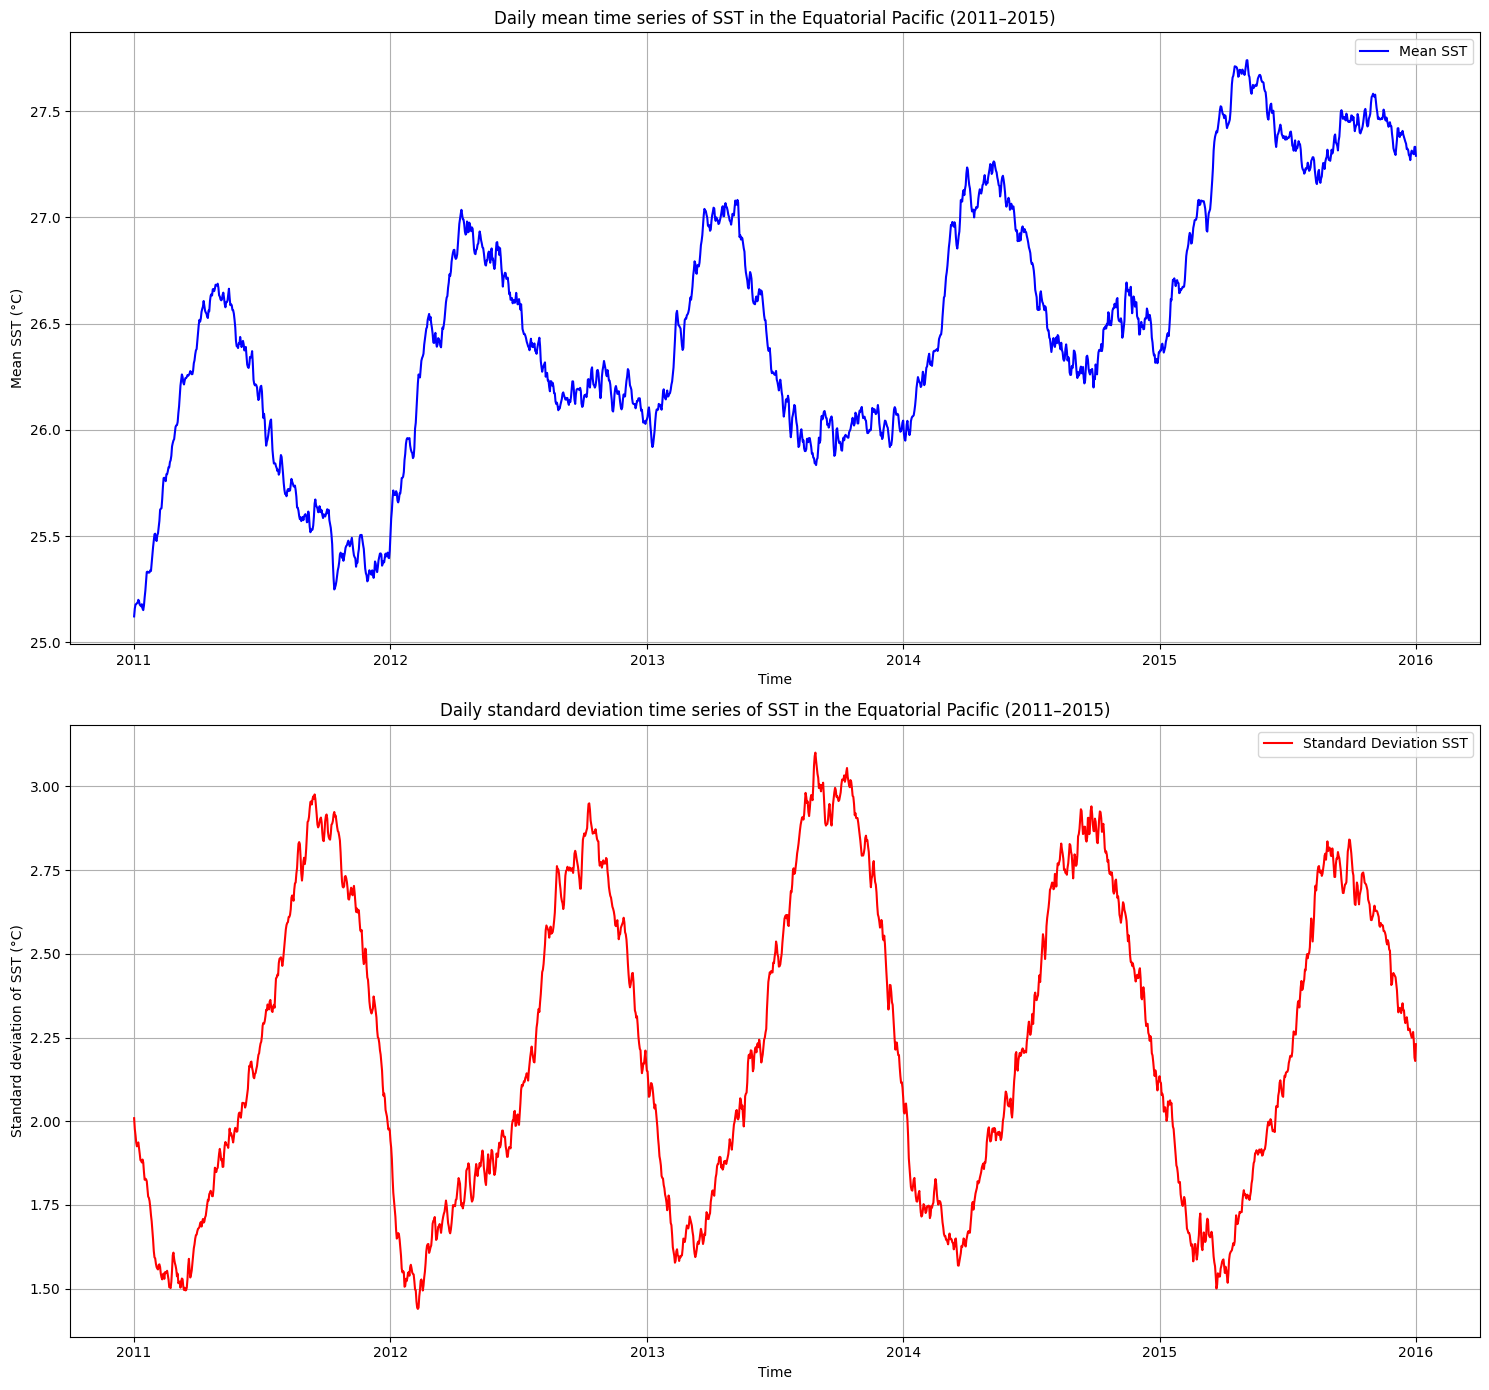

In [ ]:
#Plot
df2 = pd.DataFrame(output_q2)

n = len(df2)
df2['time'] = pd.date_range(start='2011-01-01', end='2016-01-01', periods=n)

plt.figure(figsize=(15, 14))

# Plotting mean time series
plt.subplot(2,1,1)
plt.plot(df2['time'], df2['mean_sst'], '-', color='blue', label="Mean SST")
plt.xlabel('Time')
plt.ylabel('Mean SST (°C)')
plt.title("Daily mean time series of SST in the Equatorial Pacific (2011–2015)")
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()

# Plotting standard deviation time series
plt.subplot(2,1,2)
plt.plot(df2['time'], df2['std_sst'], '-', color='red', label="Standard Deviation SST")
plt.xlabel('Time')
plt.ylabel('Standard deviation of SST (°C)')
plt.title("Daily standard deviation time series of SST in the Equatorial Pacific (2011–2015)")
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()

plt.tight_layout()
plt.show()

The mean sea surface temperature exhibits a gradual increase from 2011 to 2015, indicating a persistent warming trend over this period. The relatively stable standard deviation suggests limited interannual variability, implying that year-to-year fluctuations are small and that extreme temperature events are rare or absent in the dataset. This combination of a rising mean with low variability points to a steady warming signal rather than sporadic or episodic temperature anomalies.

### Case Study 3: Extreme Weather Impact Analysis (Typhoons)
**Region:** Pacific Ocean, South of Japan (Lon +120 to +145, Lat +20 to +40).

**Physical Context:**
Tropical cyclones draw their energy from warm ocean waters, causing a phenomenon known as "SST Cooling" or "Cold Wake" along their path.

**Methodology:**
* We compute the day-to-day SST gradient ($\Delta SST$) to isolate rapid cooling events.
* **Anomaly Detection:** We identify significant negative peaks (drops > 0.4°C/day) and cross-reference them with historical typhoon tracks to validate the thermodynamic signature of storm passages.

In [ ]:

%%bigquery output_q3 --project alert-ground-261008
SELECT AVG(sst) as sst, time
FROM bdo2020.bdo2020.2011_2015
WHERE lon>120 AND lon<145 AND lat>20 AND lat<40
GROUP BY time
ORDER BY time

Query is running:   0%|          |

Downloading:   0%|          |

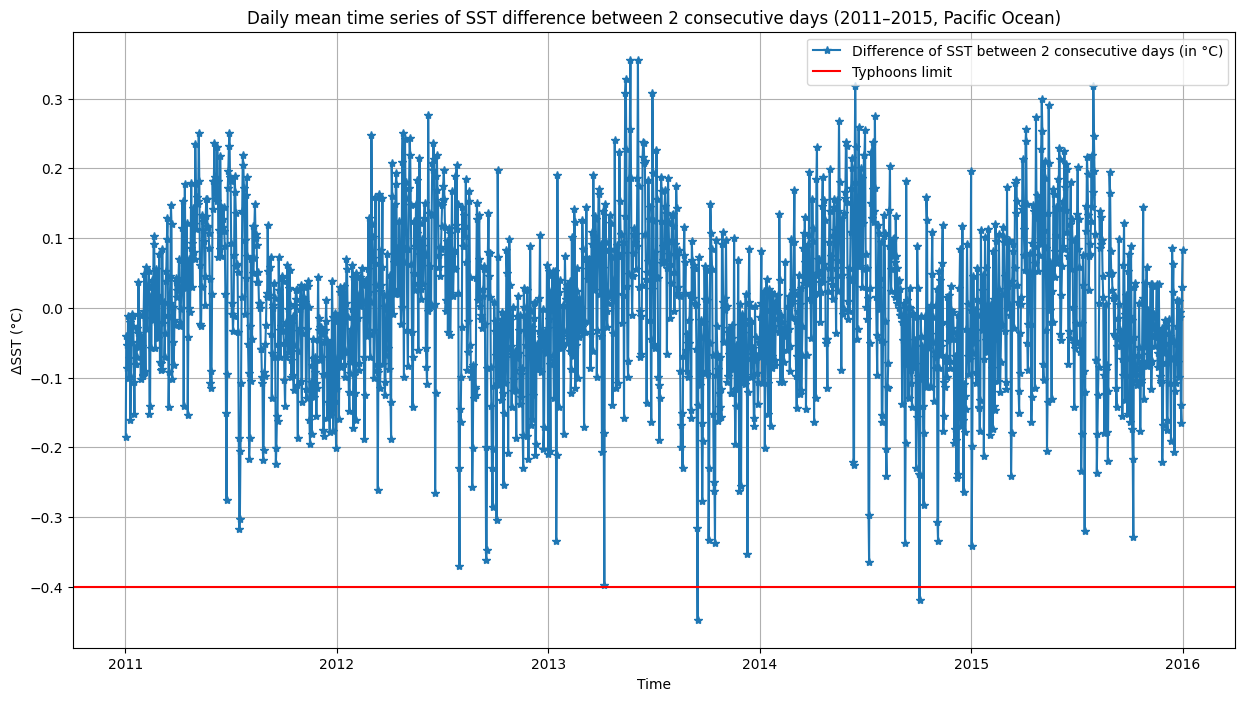

The Typhoon dates:
2013-09-15
2014-10-03


In [ ]:
### Plot QST 3
# Post-traitement: calcul de la différence SST jour-à-jour et détection des baisses fortes liées aux typhons

from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Charger la série renvoyée par BigQuery
df3 = pd.DataFrame(output_q3)

# Reconstruire un axe de temps régulier pour l'affichage
n = len(df3)
df3['time'] = pd.date_range(start='2011-01-01', end='2016-01-01', periods=n)

# Calculer la différence journalière de SST (today - yesterday)
df3['diff_sst'] = df3['sst'].diff()

# Tracer la série des différences et marquer le seuil typique pour typhons (-0.4 °C)
plt.figure(figsize=(15, 8))
plt.plot(df3['time'], df3['diff_sst'], '*-', label="Difference of SST between 2 consecutive days (in °C)")
plt.axhline(y=-0.4, label="Typhoons limit", color="red")

plt.title("Daily mean time series of SST difference between 2 consecutive days (2011–2015, Pacific Ocean)")
plt.ylabel("ΔSST (°C)")
plt.xlabel("Time")

plt.legend()
plt.grid(True)
plt.show()

# Lister les dates où la chute dépasse le seuil
typhoon_dates = df3[df3['diff_sst'] < -0.4]['time']

print("The Typhoon dates:")
for date in typhoon_dates:
    print(date.strftime("%Y-%m-%d"))

Between 2011 and 2015, two instances were identified where daily sea surface temperature variations exceeded 0.4 °C compared to the previous day. These abrupt thermal changes are most likely associated with the passage of tropical cyclones over the study area. Specifically, the typhoons occurring on 15 September 2013 and 3 October 2014 in the Pacific correspond to these anomalies. These events highlight the localized but significant impact of extreme weather phenomena on daily sea surface temperature variability.

## 3. Statistical Modeling & Time Series Decomposition (Scikit-learn)

In this final section, we move from descriptive statistics to predictive modeling using the Mediterranean Sea dataset.

### Harmonic Analysis & Linear Trend
We model the Sea Surface Temperature (SST) as a superposition of a linear climate trend and a seasonal cycle. We implement a **Linear Regression** model using *Scikit-learn*, fitted on the following harmonic equation:

$$SST(t) = \alpha_0 + \alpha_1 t + \alpha_2 \sin(2\pi\omega t) + \alpha_3 \cos(2\pi\omega t)$$

*Where $\omega = 1/365$ represents the annual frequency.*

**Model Evaluation:**
1.  **Fit Visualization:** Comparison between raw observation data and the statistical model.
2.  **Residual Analysis:** We compute the autocorrelation of residuals to assess the model's validity and check for remaining temporal structures (noise "whiteness").

In [ ]:
#Request calculating mean and stddev of SST over a specified region and time period

%%bigquery output_q4 --project alert-ground-261008
SELECT time, AVG(sst) AS mean_sst, STDDEV(sst) AS std_sst
FROM bdo2020.bdo2020.2011_2015
WHERE lon>0 AND lon<35 AND lat>30 AND lat<45
GROUP BY time
ORDER BY time

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# Prepare data for regression: extract y (mean_sst) and a time axis t
df4 = pd.DataFrame(output_q4)
y = df4.mean_sst.values
t = np.array(df4.index)

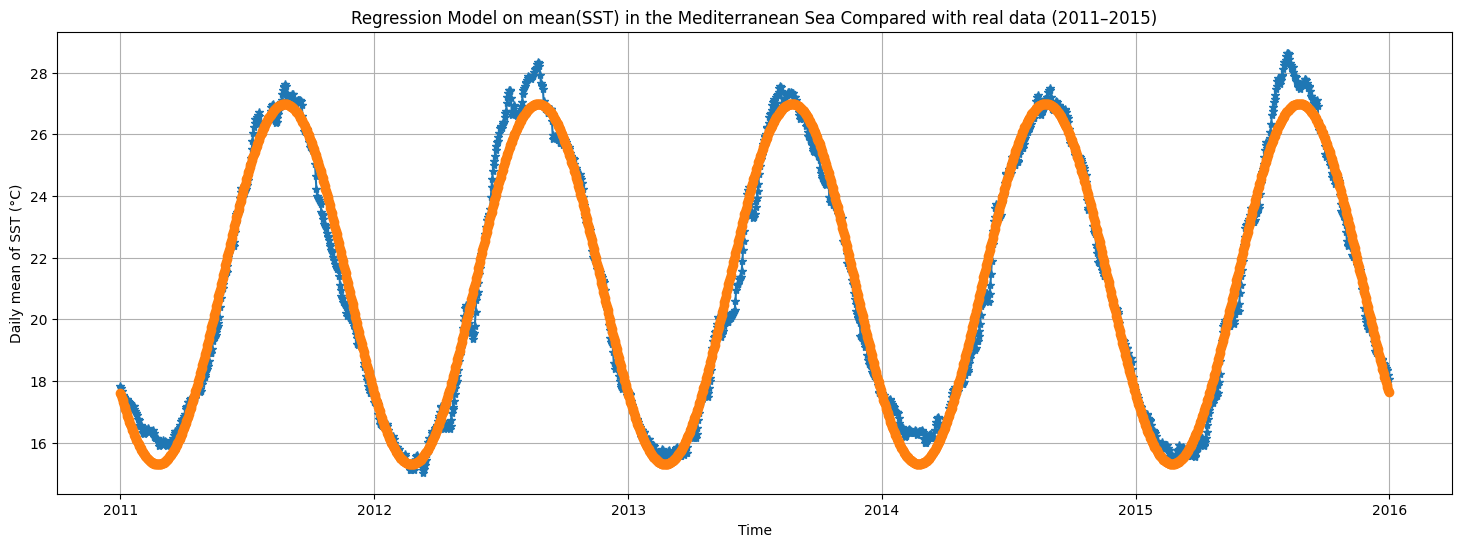

In [ ]:
#Plot 
from sklearn.linear_model import LinearRegression

def regression(t, y):
    
    w = 1/365
    X = np.array([np.ones(len(t)), t, np.sin(2*np.pi*w*t), np.cos(2*np.pi*w*t)]).T
    clf = LinearRegression().fit(X, y)
    y_pred = clf.predict(X)
    return y_pred, clf

start_date = pd.Timestamp('2011-01-01')
dates = start_date + pd.to_timedelta(t, unit='D')  # to converts t into real dates

y_pred, clf = regression(t, y)

plt.figure(figsize=(18,6))
plt.plot(dates, y, '-*', label='Real data')
plt.plot(dates, y_pred, '-o', label='Regression model')

plt.title('Regression Model on mean(SST) in the Mediterranean Sea Compared with real data (2011–2015)')
plt.ylabel('Daily mean of SST (°C)')
plt.xlabel('Time')

plt.grid(True)

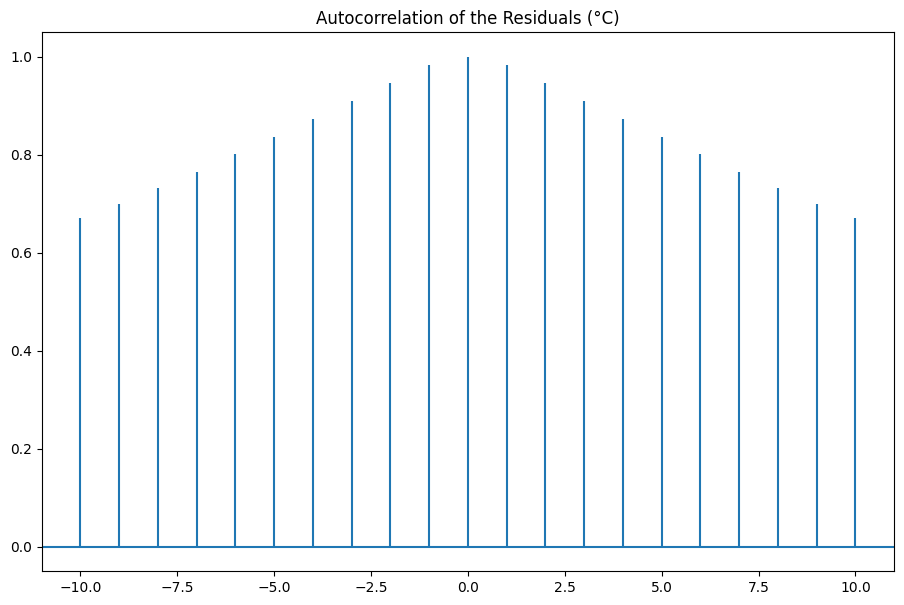

In [ ]:
# Autocorrelation of the Residuals
plt.figure(figsize=(11,7))
plt.acorr(y-y_pred)
plt.title('Autocorrelation of the Residuals (°C)')
plt.show()

A strong correlation among the residuals suggests that the selected regression model provides a good fit to the data. The model effectively captures the temporal variability observed in the measurements, indicating that it reliably represents the underlying trends and patterns in the dataset.

## 5. Global Climate Trends: Sea Level Rise (SLR) Assessment

### Spatial Analysis: Regional Sea Level Anomalies
We compute the net difference in Sea Surface Height (SSH) between the beginning of the observation period (2011) and the end (2015) for every grid point on the globe.
* **Objective:** Highlight the spatial heterogeneity of sea level rise. While the global average increases, some regions may experience sharper rises due to local thermodynamic effects, while others may remain stable.

### Long-Term Forecasting (Horizon 2100)
Using the Global Mean Sea Level (GMSL) computed over all locations, we fit a linear regression model to extract the global trend.
* **Projection:** We extrapolate this linear trend to estimating the GMSL in **2100**.
* **Disclaimer:** *This projection is based on a linear extrapolation of a 5-year dataset and serves as a theoretical exercise. Accurate long-term climate modelling would require multi-decadal data and non-linear physics-based models.*

In [ ]:
# Request finding time bounds (t0, t1) in the dataset
%%bigquery bounds --project alert-ground-261008
-- This cell finds the overall min(time) and max(time) in the dataset.
-- We will use these bounds as t0 (first day) and t1 (last day) for SSH differencing.
SELECT
  MIN(time) AS t0,
  MAX(time) AS t1
FROM `bdo2020.bdo2020.2011_2015`


Query is running:   0%|          |

Downloading:   0%|          |

In [67]:
bounds


t0        t1
0  734138.0  735963.0

In [68]:
%%bigquery ssh_summary --project alert-ground-261008


-- This query computes summary statistics and approximate quantiles of ΔSSH (t1 - t0)

WITH bounds AS (
  SELECT MIN(time) AS t0, MAX(time) AS t1
  FROM `bdo2020.bdo2020.2011_2015`
),
cells AS (
  -- Compute ssh_t0 and ssh_t1 per grid cell (lon,lat)
  SELECT
    s.lon,
    s.lat,
    -- valeurs aux bornes
    AVG(IF(s.time = b.t0, s.ssh, NULL)) AS ssh_t0,
    AVG(IF(s.time = b.t1, s.ssh, NULL)) AS ssh_t1
  FROM `bdo2020.bdo2020.2011_2015` AS s
  CROSS JOIN bounds AS b
  GROUP BY s.lon, s.lat
),
ssh_change AS (
  -- Compute the per-cell change
  SELECT
    lon,
    lat,
    ssh_t0,
    ssh_t1,
    (ssh_t1 - ssh_t0) AS ssh_change
  FROM cells
),
q AS (
  -- Basic aggregated statistics across all cells
  SELECT
    COUNT(*) AS n_cells,
    AVG(sc.ssh_change)     AS mean_change,
    STDDEV(sc.ssh_change)  AS std_change,
    MIN(sc.ssh_change)     AS min_change,
    MAX(sc.ssh_change)     AS max_change
  FROM ssh_change AS sc
),
p AS (
  -- Approximate quantiles and share of cells with positive change
  SELECT
    APPROX_QUANTILES(sc.ssh_change, 101) AS qtiles,
    AVG(CASE WHEN sc.ssh_change > 0 THEN 1 ELSE 0 END) AS share_positive
  FROM ssh_change AS sc
)
-- Combine summary and selected quantiles into a single row result
SELECT
  q.n_cells,
  q.mean_change,
  q.std_change,
  q.min_change,
  q.max_change,
  p.qtiles[OFFSET(5)]   AS p05,
  p.qtiles[OFFSET(25)]  AS p25,
  p.qtiles[OFFSET(50)]  AS p50,
  p.qtiles[OFFSET(75)]  AS p75,
  p.qtiles[OFFSET(95)]  AS p95,
  p.share_positive
FROM q
CROSS JOIN p


Query is running:   0%|          |

Downloading:   0%|          |

In [69]:
ssh_summary


n_cells  mean_change  std_change  min_change  max_change     p05     p25  \
0   563683     0.030915    0.141883     -1.1003      1.3858 -0.1977 -0.0342   

      p50     p75     p95  share_positive  
0  0.0256  0.0962  0.2477        0.586335

In [70]:
%%bigquery daily_ssh --project alert-ground-261008

-- Build a daily time series of global mean SSH (average across all grid cells)
-- Input `time` appears numeric (days since origin); we reconstruct a DATE using an origin.

WITH params AS (
  SELECT DATE '2011-01-01' AS origin
),
ts AS (
  SELECT
    DATE_ADD((SELECT origin FROM params), INTERVAL CAST(FLOOR(time) AS INT64) DAY) AS d,
    ssh
  FROM `bdo2020.bdo2020.2011_2015`
)

-- Average across all cells for each day

SELECT
  d,
  AVG(ssh) AS ssh_mean
FROM ts
GROUP BY d
ORDER BY d


Query is running:   0%|          |

Downloading:   0%|          |

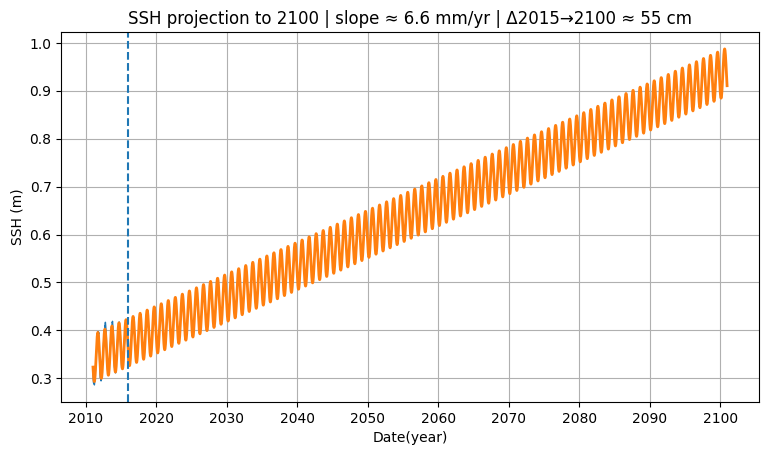


Summary (global trend):
- Fit window (reconstructed): 2011-01-01 → 2015-12-31
- Linear slope: 6.64 mm/yr
- Modelled rise 2015→2100: 550 mm


In [ ]:


# We prepare the daily mean SSH series returned from the previous SQL cell,
# fit a linear trend + annual seasonality model, then predict up to 2100
# 0) Ensure the SQL result is ordered by date and index is reset
# daily_ssh is a pandas DataFrame from the earlier Bigquery cell

try:
    daily_ssh = daily_ssh.sort_values('d').reset_index(drop=True)
except Exception:
    daily_ssh = daily_ssh.reset_index(drop=True)

# Extract the SSH series as a floating-point numpy array
y = daily_ssh['ssh_mean'].astype(float).values

# Reconstruct time axis t = 0,1,... where day 0 = 2011-01-01
t0_date      = pd.Timestamp('2011-01-01')
t            = np.arange(len(y), dtype=float)

# Design matrix: intercept, linear trend (t), annual sinusoidal components
w = 1/365.0
X = np.column_stack([np.ones_like(t),
                     t,
                     np.sin(2*np.pi*w*t),
                     np.cos(2*np.pi*w*t)])

# Fit linear regression (ordinary least squares)
model = LinearRegression().fit(X, y)
y_hat = model.predict(X)

# Convert slope from m/day to m/year
slope_per_year = model.coef_[1] * 365.0


# Build a prediction grid from the dataset start until 2100-12-31
t_2015_end = (pd.Timestamp('2015-12-31') - t0_date).days
t_2100     = (pd.Timestamp('2100-12-31') - t0_date).days

t_grid = np.arange(int(t.min()), int(t_2100) + 1, 7)  # hebdo
Xg = np.column_stack([np.ones_like(t_grid),
                      t_grid,
                      np.sin(2*np.pi*w*t_grid),
                      np.cos(2*np.pi*w*t_grid)])
yg = model.predict(Xg)

ssh_2015 = float(model.predict([[1, t_2015_end,
                                 np.sin(2*np.pi*w*t_2015_end),
                                 np.cos(2*np.pi*w*t_2015_end)]]))
ssh_2100 = float(model.predict([[1, t_2100,
                                 np.sin(2*np.pi*w*t_2100),
                                 np.cos(2*np.pi*w*t_2100)]]))
delta_2015_2100 = ssh_2100 - ssh_2015  # en m

# Reconstruct dates arrays for plotting

dates_obs  = t0_date + pd.to_timedelta(t.astype(int), unit='D')
dates_grid = t0_date + pd.to_timedelta(t_grid.astype(int), unit='D')

# Plotting

plt.figure(figsize=(9,4.8))
plt.plot(dates_obs, y, label="Observed global mean SSH", linewidth=1)
plt.plot(dates_grid, yg, label="Model (linear + annual)", linewidth=2)
plt.axvline(pd.Timestamp("2015-12-31"), linestyle="--", label="End 2015")
plt.title(f"SSH projection to 2100 | slope ≈ {slope_per_year*1000:.1f} mm/yr | Δ2015→2100 ≈ {delta_2015_2100*100:.0f} cm")
plt.xlabel("Date(year)")
plt.ylabel("SSH (m)")
plt.grid(True)
plt.show()
print("\nSummary (global trend):")
print(f"- Fit window (reconstructed): {t0_date.date()} → 2015-12-31")
print(f"- Linear slope: {slope_per_year*1000:.2f} mm/yr")
print(f"- Modelled rise 2015→2100: {delta_2015_2100*1000:.0f} mm")


In [72]:
%%bigquery ssh_map_data --project alert-ground-261008

-- ΔSSH = SSH(t1) - SSH(t0) par cellule (lon,lat)

WITH b AS (
  SELECT MIN(time) AS t0, MAX(time) AS t1
  FROM `bdo2020.bdo2020.2011_2015`
)
SELECT
  s.lon,
  s.lat,
  AVG(IF(s.time = b.t1, s.ssh, NULL)) - AVG(IF(s.time = b.t0, s.ssh, NULL)) AS ssh_change
FROM `bdo2020.bdo2020.2011_2015` AS s
CROSS JOIN b
GROUP BY s.lon, s.lat;


Query is running:   0%|          |

Downloading:   0%|          |

Total cells plotted: 531804
Mean ΔSSH (m): 3.0915e-02, std: 1.4188e-01


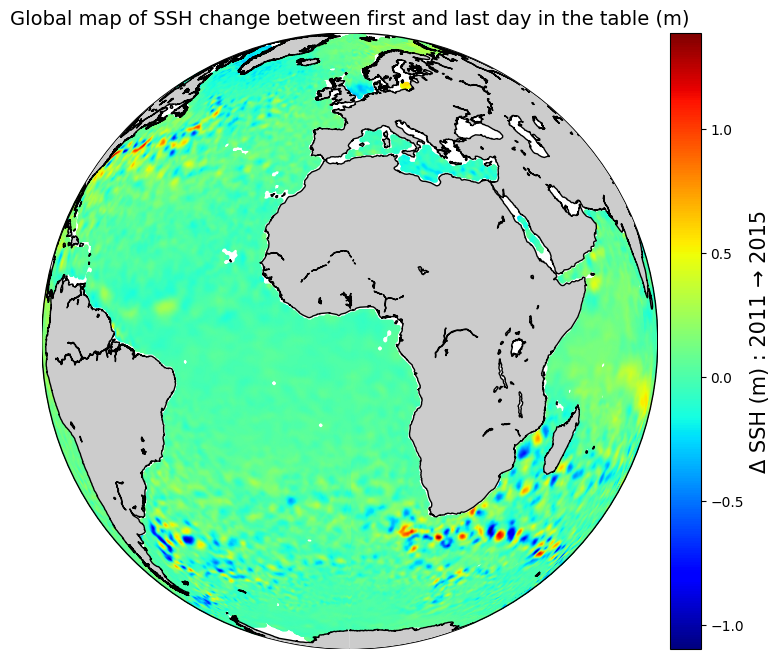

In [ ]:

# Prepare data for mapping ΔSSH

df_map = pd.DataFrame(ssh_map)

df_map.columns = df_map.columns.str.strip()

col = None
for c in df_map.columns:
    if c.strip().lower() == 'ssh_change':
        col = c
        break
if col is None:
    raise AssertionError(f"Column 'ssh_change' not found in {list(df_map.columns)}")

df_map[col] = pd.to_numeric(df_map[col], errors='coerce')

valid = np.isfinite(df_map[col].values)
lon = df_map['lon'].values[valid]
lat = df_map['lat'].values[valid]
ssh_change = df_map[col].values[valid]

# Quick diagnostics
print(f'Total cells plotted: {len(ssh_change)}')
print(f'Mean ΔSSH (m): {np.nanmean(ssh_change):.4e}, std: {np.nanstd(ssh_change):.4e}')

# Plot the map (uses the plot_im function already defined in the notebook)
plt.figure(figsize=(12,8))
# for the global map we use a moderate size_points
plot_im(lon, lat, ssh_change, 8, 'Δ SSH (m) : 2011 → 2015')
plt.title('Global map of SSH change between first and last day in the table (m)', size=14)
plt.show()

R² (2011–2015): 0.950
Estimated seasonal amplitude (peak-to-peak): 99.4 mm
Residuals: mean=0.00 mm, std=8.70 mm, min=-23.2 mm, max=19.4 mm


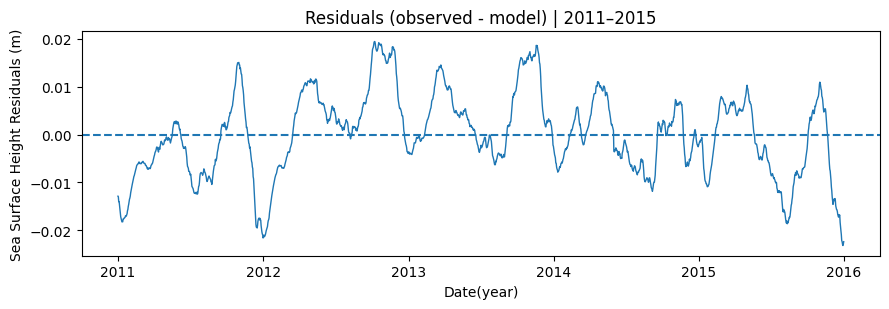

In [ ]:

# Computing goodness of fit metrics and inspect residuals to evaluate model adequacy on 2011–2015.

from sklearn.metrics import r2_score

# R² for the fitted period (2011–2015)
r2 = r2_score(y, y_hat)

# Seasonal amplitude: amplitude A = sqrt(a2^2 + a3^2), peak-to-peak = 2*A
A = np.sqrt(model.coef_[2]**2 + model.coef_[3]**2)
amp_pk2pk = 2 * A


# Residual summary (observed minus fitted)

res = y - y_hat
print(f"R² (2011–2015): {r2:.3f}")
print(f"Estimated seasonal amplitude (peak-to-peak): {amp_pk2pk*1000:.1f} mm")
print(f"Residuals: mean={res.mean()*1000:.2f} mm, std={res.std()*1000:.2f} mm, min={res.min()*1000:.1f} mm, max={res.max()*1000:.1f} mm")

# Plotting
plt.figure(figsize=(9,3.2))
plt.plot(dates_obs, res, linewidth=1)
plt.axhline(0, linestyle="--")
plt.title("Residuals (observed - model) | 2011–2015")
plt.xlabel("Date(year)")
plt.ylabel("Sea Surface Height Residuals (m)")
plt.tight_layout()
plt.show()


In [76]:
%%bigquery ssh_sample --project alert-ground-261008

-- We want here to return a random sample of ΔSSH (ssh_t1 - ssh_t0) across cells for plotting.

WITH bounds AS (
  SELECT MIN(time) AS t0, MAX(time) AS t1
  FROM `bdo2020.bdo2020.2011_2015`
),
cells AS (
  SELECT
    s.lon, s.lat,
    AVG(IF(s.time = b.t0, s.ssh, NULL)) AS ssh_t0,
    AVG(IF(s.time = b.t1, s.ssh, NULL)) AS ssh_t1
  FROM `bdo2020.bdo2020.2011_2015` AS s
  CROSS JOIN bounds AS b
  GROUP BY s.lon, s.lat
)
SELECT CAST(ssh_t1 - ssh_t0 AS FLOAT64) AS ssh_change
FROM cells
WHERE RAND() < 0.02  -- approximating 2% random sample and avoiding transferring full global array


Query is running:   0%|          |

Downloading:   0%|          |

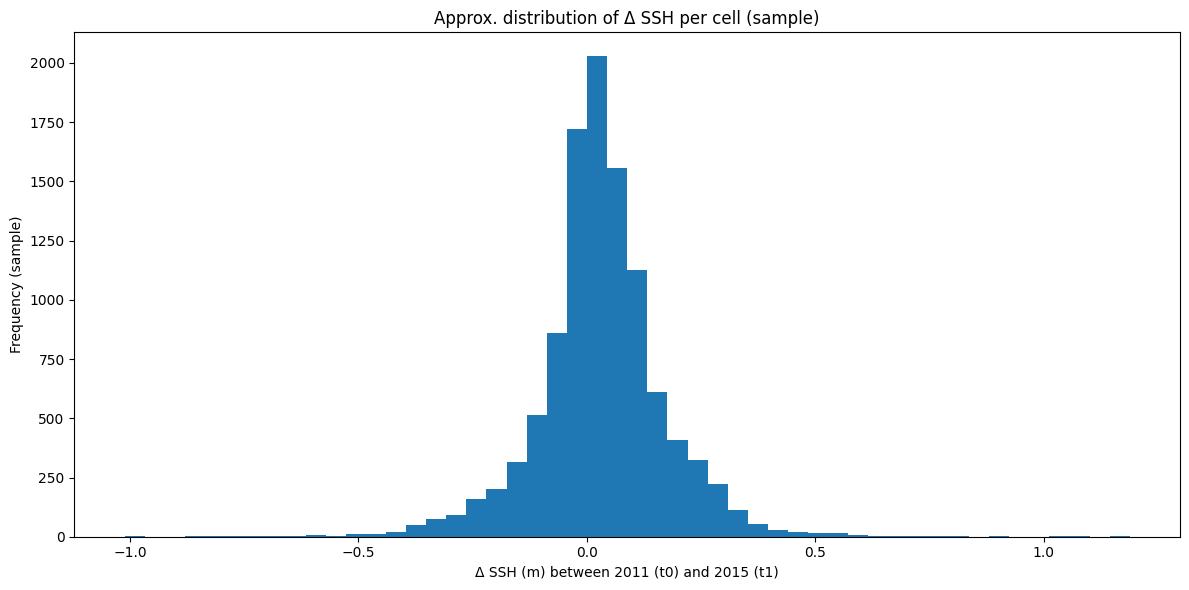

Sample summary (numeric):
count    10606.000000
mean         0.029863
std          0.141018
min         -1.011600
25%         -0.033200
50%          0.026400
75%          0.099400
max          1.188000
Name: ssh_change, dtype: float64
% of sampled cells with Δ > 0 : 61.8%


In [ ]:


# Here we clean the sampled SQL result to ensure the 'ssh_change' column is numeric, and then plot a histogram and print summary statistics for the sample.

# Normalizing column names (strip whitespace)
ssh_sample.columns = ssh_sample.columns.str.strip()

# Finding the 'ssh_change' column in a case-insensitive way
col = None
for c in ssh_sample.columns:
    if c.strip().lower() == "ssh_change":
        col = c
        break
assert col is not None, f"Column 'ssh_change' not found in {list(ssh_sample.columns)}"

# Converting to numeric aggressively (remove spaces, replace commas with dots)
s = ssh_sample[col].astype(str)
s = s.str.replace(r"\s+", "", regex=True).str.replace(",", ".")
s = pd.to_numeric(s, errors="coerce")
s = s[np.isfinite(s)]

if s.empty:
    raise ValueError("After conversion no numeric values remain. Consider using CAST(FLOAT64) in SQL.")

# Plot histogram (sample distribution of ΔSSH per cell)
ax = s.plot(kind="hist", bins=50)
ax.set_xlabel("Δ SSH (m) between 2011 (t0) and 2015 (t1)")
ax.set_ylabel("Frequency (sample)")
ax.set_title("Approx. distribution of Δ SSH per cell (sample)")
ax.figure.set_size_inches(12,6)
plt.tight_layout()
plt.show()

# 5) Print numeric summary useful for report
print("Sample summary (numeric):")
print(s.describe())
print(f"% of sampled cells with Δ > 0 : {(s > 0).mean()*100:.1f}%")


 The analysis reveals a consistent global increase in Sea Surface Height (SSH) between 2011 and 2015, with approximately 61.6% of ocean cells showing positive elevation changes. This upward trend, confirmed by the regression model and stable residuals, indicates a robust long-term rise in global mean sea level. Local variability exists, but the overall signal reflects the ongoing impact of climate change, primarily driven by glacial melt and ocean thermal expansion.